In [1]:
import os
import sys
sys.path.append('../../hetnet-ml/src')
import graph_tools as gt
import pickle
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
nodes = pd.read_csv('../data/nodes_VER31_R_condensed.csv')
edges = pd.read_csv('../data/edges_VER31_R_condensed.csv', converters={'pmids':eval})

# remove : character from column names to make them queryable
nodes = gt.remove_colons(nodes)
edges = gt.remove_colons(edges)

In [3]:
comps = (nodes['label'] == 'Chemicals & Drugs').sum() 
diseases = (nodes['label'] == 'Disorders').sum()

print('{:,} Compounds x {:,} Diseases = {:,} C-D pairs'.format(comps, diseases, comps*diseases))

96,722 Compounds x 42,340 Diseases = 4,095,209,480 C-D pairs


In [4]:
nodes.head(2)

,id,label,name
0,C0349450,Activities & Behaviors,Soiling
1,C0681398,Activities & Behaviors,teacher behavior


In [5]:
edges.head(2)

,start_id,end_id,type,pmids,n_pmids
0,C1273870,C1138603,ADMINISTERED_TO_ABatCI,"{15842188, 12943031}",2
1,C1273870,C0600241,ADMINISTERED_TO_ABatDO,{24831754},1


In [6]:
counts = edges["type"].value_counts()
counts

LOCATION_OF_AloCD            1054383
ASSOCIATED_WITH_DOawDO        790847
INTERACTS_WITH_CDiwG          720844
TREATS_CDtDO                  642444
AFFECTS_DOafLB                623001
LOCATION_OF_AloDO             559061
LOCATION_OF_AloG              548179
PRODUCES_LBpdCD               533869
STIMULATES_CDstCD             529910
REGULATES_CDreg>CD            453630
TREATS_PRtDO                  443230
STIMULATES_CDstG              388773
AFFECTS_CDafA                 340870
ASSOCIATED_WITH_GawDO         327040
USES_PRuCD                    303419
LOCATION_OF_AloA              271979
PART_OF_GpoLB                 266246
AFFECTS_GafPS                 259853
RELATED_TO_CDrtCD             249204
INHIBITS_CDinG                246507
INTERACTS_WITH_GiwG           241686
AUGMENTS_CDagPS               238387
DIAGNOSES_PRdgDO              224615
METHOD_OF_PRmoPR              213686
REGULATES_Greg>G              205363
DISRUPTS_CDdsPS               194084
OCCURS_IN_AoiLB               163137
A

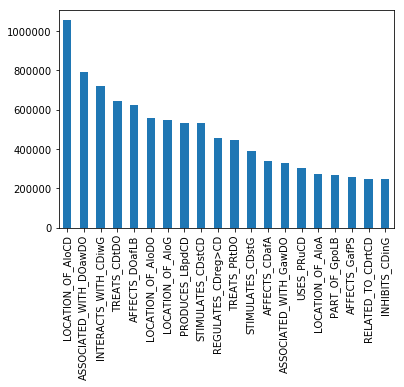

In [7]:
counts[:20].plot(kind='bar');

# Filter out the lower count edge types

In [8]:
'{:,}'.format(edges.shape[0])

'14,526,080'

In [17]:
cutoff = .003

print("Number of edge types with this cutoff: {}".format((counts > cutoff*len(edges)).sum()))
print("Number of edges that remain with this cutoff: {:,}".format(counts[counts > cutoff*len(edges)].sum()))

Number of edge types with this cutoff: 49
Number of edges that remain with this cutoff: 13,016,011


In [18]:
ok_edges = list(counts[counts > cutoff*len(edges)].index)

In [19]:
result = edges.query('type in @ok_edges')

In [20]:
'{:,}'.format(result.shape[0])

'13,016,011'

# Some quick validation that all ids are the same between nodes and edges

In [21]:
edge_ids = set(result['start_id'].unique()).union(set(result['end_id'].unique()))

In [22]:
node_ids = set(nodes['id'].unique())

In [23]:
not_in_edges = node_ids - edge_ids

In [24]:
not_in_edges = list(not_in_edges)

In [25]:
idx = nodes.query('id in @not_in_edges').index
nodes.loc[idx]

,id,label,name
0,C0349450,Activities & Behaviors,Soiling
1,C0681398,Activities & Behaviors,teacher behavior
2,C0015259,Activities & Behaviors,Exercise
3,C1512169,Activities & Behaviors,Education Projects
4,C0681394,Activities & Behaviors,misconduct
5,C0027776,Activities & Behaviors,Nesting Behavior
6,C1512182,Activities & Behaviors,Electrolaryngeal Speech
7,C0031828,Activities & Behaviors,Physician's Practice Patterns
8,C0233528,Activities & Behaviors,Asocial behavior
9,C0681390,Activities & Behaviors,student behavior


In [26]:
nodes = nodes.drop(idx)

In [27]:
len(nodes)

239699

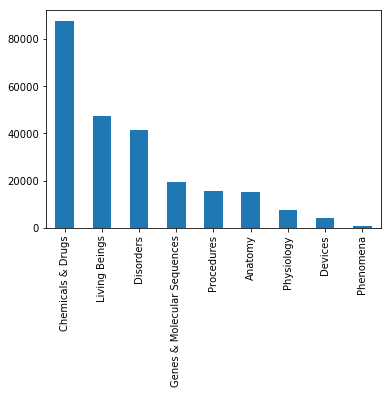

In [28]:
nodes['label'].value_counts().plot(kind='bar');

# Do some EDA

In [29]:
combo = gt.combine_nodes_and_edges(gt.add_colons(nodes), gt.add_colons(result[['start_id', 'end_id', 'type', 'n_pmids']]))
combo = gt.remove_colons(combo)

In [30]:
combo.head(2)

,start_id,end_id,type,n_pmids,start_name,end_name,start_label,end_label
737,C0015491,C0025932,ADMINISTERED_TO_CDatLB,1,Factor IX,"Mice, Nude",Chemicals & Drugs,Living Beings
738,C0041017,C0036945,ADMINISTERED_TO_CDatLB,1,Reverse Triiodothyronine,Sheep,Chemicals & Drugs,Living Beings


In [31]:
max_edge = combo["n_pmids"].max()
combo.query('n_pmids == @max_edge')

,start_id,end_id,type,n_pmids,start_name,end_name,start_label,end_label
13747161,C0087111,C0030705,TREATS_PRtLB,154608,Therapeutic procedure,Patients,Procedures,Living Beings


In [32]:
frame = pd.DataFrame()
for i in range(10):

    to_plot = combo.query('n_pmids > @i')['type'].value_counts()
    to_plot = to_plot / to_plot.sum()
    frame[i+1] = to_plot

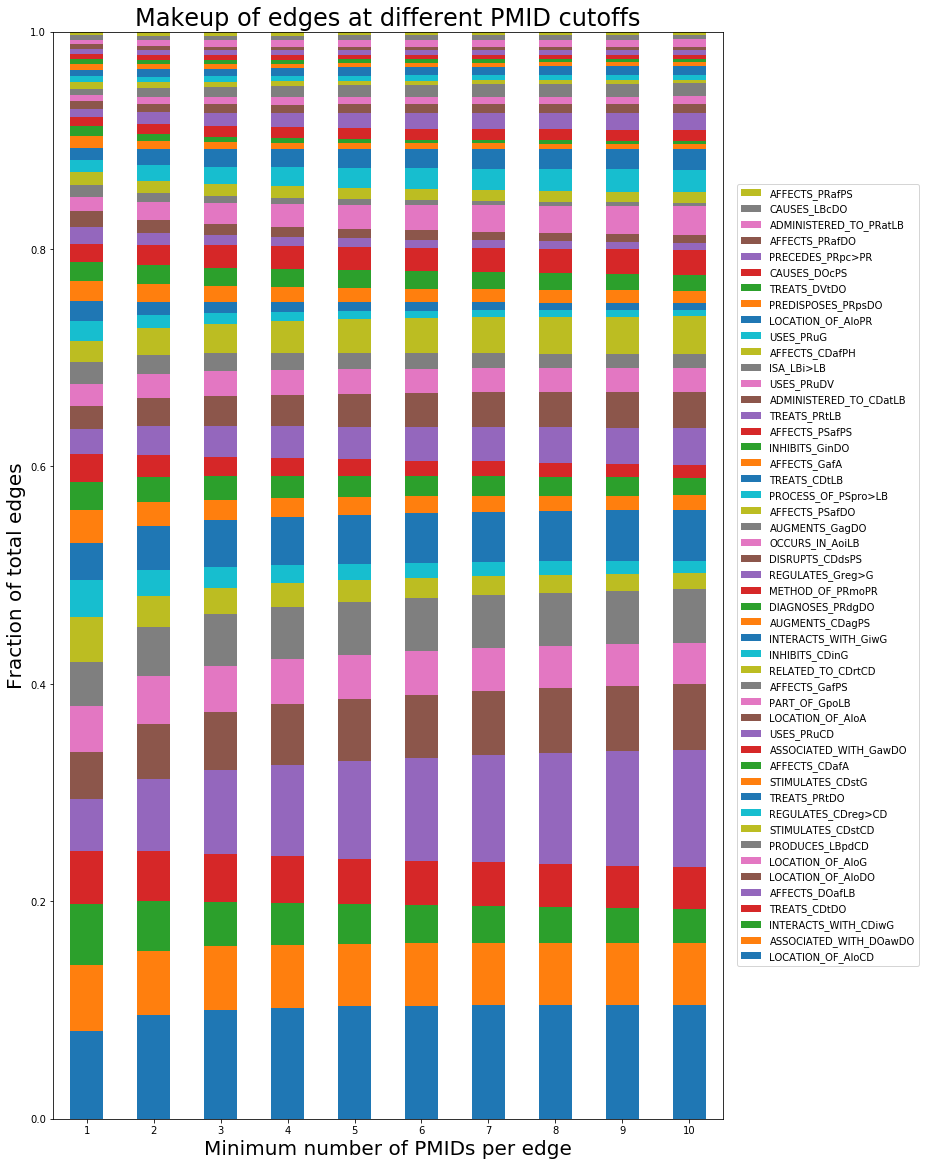

In [33]:
fig = frame.T.plot.bar(stacked=True, figsize=(12, 20))
handels, labels = fig.axes.get_legend_handles_labels()
plt.legend(handels[::-1], labels[::-1], loc=7, bbox_to_anchor=(1.3, 0.5))
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.title('Makeup of edges at different PMID cutoffs', size=24)
plt.xlabel('Minimum number of PMIDs per edge', size=20)
plt.ylabel('Fraction of total edges', size = 20);

In [34]:
combo.sort_values('n_pmids', ascending=False)[['n_pmids', 'start_name', 'type', 'end_name']].iloc[:60]

,n_pmids,start_name,type,end_name
13747161,154608,Therapeutic procedure,TREATS_PRtLB,Patients
1009425,116754,Disease,AFFECTS_DOafLB,Patients
13814030,98678,Operative Surgical Procedures,TREATS_PRtLB,Patients
964191,68547,Symptoms,AFFECTS_DOafLB,Patients
1100047,63372,Malignant Neoplasms,AFFECTS_DOafLB,Patients
635876,60231,Complication,AFFECTS_DOafLB,Patients
123333,55179,Therapeutic procedure,ADMINISTERED_TO_PRatLB,Patients
1161212,54692,Diabetic,AFFECTS_DOafLB,Patients
1035695,54104,Neoplasm,AFFECTS_DOafLB,Patients
821268,49274,Lesion,AFFECTS_DOafLB,Patients


In [35]:
combo.query('start_id == end_id')['type'].value_counts()

INTERACTS_WITH_GiwG       3564
REGULATES_Greg>G          3262
RELATED_TO_CDrtCD          255
ISA_LBi>LB                 181
ASSOCIATED_WITH_DOawDO     142
STIMULATES_CDstCD           67
METHOD_OF_PRmoPR            52
REGULATES_CDreg>CD          42
LOCATION_OF_AloA            31
AFFECTS_PSafPS              26
PRECEDES_PRpc>PR            13
Name: type, dtype: int64

There are some instances of self-referrential edges.  These should be removed as they are not vaild in DWPC feature extraction.

In [36]:
result = gt.remove_colons(result)
idx = result.query('start_id == end_id').index
result = result.drop(idx)

In [37]:
node_degrees = pd.concat([combo['start_name'], combo['end_name']]).value_counts()

In [38]:
node_degrees[:60]

Patients                         92345
Therapeutic procedure            70038
Cells                            58863
Disease                          50319
Rattus norvegicus                47882
Mus                              42921
Homo sapiens                     41430
Genes                            40687
Child                            37883
Proteins                         37554
Pharmaceutical Preparations      35960
Woman                            33072
Body tissue                      30668
Neoplasm                         28960
Individual                       28774
Operative Surgical Procedures    27508
Brain                            27404
Animals                          26424
Growth                           26313
Adult                            26166
Liver                            25759
Malignant Neoplasms              24457
Canis familiaris                 23067
Cell Line                        21923
Enzymes                          20725
Apoptosis                

In [39]:
#These are from the 100 most common nodes, removing things that are too general to be usefl

too_general = ['Patients', 'Cells', 'Disease', 'Therapeutic procedure', 'Proteins', 'Pharmaceutical Preparations',
 'Mus', 'Human', 'Child', 'Genes', 'Woman', 'Body tissue', 'Malignant Neoplasms', 'Growth', 'Individual', 'Antibodies',
 'Operative Surgical Procedures', 'Adult', 'Enzymes', 'Symptoms', 'Syndrome', 'Animals', 'Cell Line', 'Injury', 'Complication',
 'House mice', 'Functional disorder', 'Infant', 'Family', 'Persons', 'Male population group', 'Monoclonal Antibodies',
 'Toxic effect', 'Infection', 'DNA Sequence', 'Control Groups', 'Injection procedure', 'Ions', 'Transcription, Genetic',
 'Organ', 'TRANSCRIPTION FACTOR', 'cohort']

In [40]:
idx = nodes.query('name in @too_general').index
nodes = nodes.drop(idx).reset_index(drop=True)

In [41]:
node_ids = nodes['id'].unique()

In [42]:
result = result.query('start_id in @node_ids and end_id in @node_ids')

In [43]:
'{:,} Edges remain'.format(len(result))

'11,958,067 Edges remain'

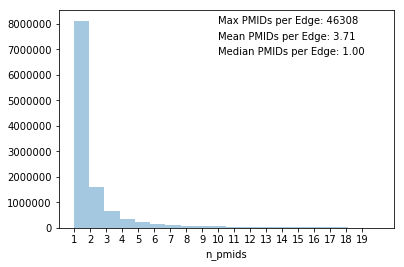

In [44]:
sns.distplot(result[result['n_pmids'] < 21]['n_pmids'], bins=20, kde=False)
plt.xticks(np.arange(1, 20, 1))
plt.text(10, 0.8e7, 'Max PMIDs per Edge: {}'.format(result['n_pmids'].max()))
plt.text(10, 0.74e7, 'Mean PMIDs per Edge: {:1.2f}'.format(result['n_pmids'].mean()))
plt.text(10, 0.68e7, 'Median PMIDs per Edge: {:1.2f}'.format(result['n_pmids'].median()));

In [45]:
for i in range(1, 11):
    print("Edges with at least {} unique PMIDs: {:,}".format(i, (result['n_pmids'] >= i).sum()))

Edges with at least 1 unique PMIDs: 11,958,067
Edges with at least 2 unique PMIDs: 3,834,456
Edges with at least 3 unique PMIDs: 2,239,853
Edges with at least 4 unique PMIDs: 1,578,663
Edges with at least 5 unique PMIDs: 1,217,731
Edges with at least 6 unique PMIDs: 990,080
Edges with at least 7 unique PMIDs: 833,175
Edges with at least 8 unique PMIDs: 718,464
Edges with at least 9 unique PMIDs: 630,320
Edges with at least 10 unique PMIDs: 561,289


In [46]:
result = gt.add_colons(result)
nodes = gt.add_colons(nodes)

result.to_csv('../data/edges_VER31_R_condensed_filtered_003.csv', index=False)
nodes.to_csv('../data/nodes_VER31_R_condensed_filtered_003.csv', index=False)